# Import Dependencies

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import confusion_matrix

In [ ]:
!pip -q install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/competitions/aptos2019-blindness-detection/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anhnguyen14
Your Kaggle Key: ··········


IndexError: tuple index out of range

# Data

In [ ]:
train_csv = pd.read_csv('/content/aptos2019-blindness-detection/train.csv')
train_labels = train_csv['diagnosis'].values



In [ ]:
train_imgs = glob('/content/aptos2019-blindness-detection/train_images/*')
test_imgs = glob('/content/aptos2019-blindness-detection/test_images/*')

In [ ]:
# # Read csv file
# df = pd.read_csv('/content/aptos2019-blindness-detection/train.csv')
# df['image_path'] = 'aptos2019-blindness-detection/train_images/' + df['id_code'] + '.png'

# # Split the data
# from sklearn.model_selection import train_test_split
# X_train, X_eval, y_train, y_eval = train_test_split(df['image_path'].values, df['diagnosis'].values, test_size=0.3, random_state=42, stratify=df['diagnosis'].values)

# X_train = X_train.values
# X_eval = X_eval.values
# y_train = y_train.values
# y_eval = y_eval.values

# # Print the length of train & test
# print(len(X_train), len(X_eval), len(y_train), len(y_eval))

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
import cv2

class Blindness_dataset(Dataset):
    def __init__(self,
                image_folder = None,
                data_csv_path = None,
                hist_feature=[0, 1, 2],
                transform = None,
                image_size=384,
                preprocess=False):

        self.image_folder = Path(image_folder)
        self.data_csv = pd.read_csv(data_csv_path)
        self.hist_feature = hist_feature
        self.transform = transform
        self.SIZE = image_size
        self.preprocess = preprocess

    def __repr__(self) -> str:
        body = f"""Dataset {self.__class__.__name__}
        Number of datapoints: {len(self.data_csv)}
        Image location: {self.image_folder}
        Transform: {self.transform}
        Using Hist Feature: {self.hist_feature}"""
        return body

    @staticmethod
    def crop_image_from_gray(img,tol=7):
        if img.ndim ==2:
            mask = img > tol
            return img[np.ix_(mask.any(1),mask.any(0))]
        elif img.ndim==3:
            gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            mask = gray_img > tol

            check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
            if (check_shape == 0): # image is too dark so that we crop out everything,
                return img # return original image
            else:
                img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
                img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
                img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
                img = np.stack([img1,img2,img3],axis=-1)
            return img

    @staticmethod
    def TinhHist(img, channel):
        hist = cv2.calcHist(img,[channel], None, [256], [0,256])
        size = img.shape[0]*img.shape[1]
        hist = hist / size
        return hist


    def __len__(self):
        return len(self.data_csv)


    def extract_hist_feature(self, image_path, channels=[0, 1, 2]):

        image = cv2.imread(image_path, 0) if len(channels) == 1 else cv2.imread(image_path)
        image = Blindness_dataset.crop_image_from_gray(image) # Circle crop
        image = cv2.resize(image, (self.SIZE, self.SIZE))

        if self.preprocess:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , 10) ,-4 ,128)

        features = 0
        for channel in channels:
            features += Blindness_dataset.TinhHist(image, channel).flatten()

        return features / len(channels) # Mean

    def __getitem__(self, idx):

        # Load and Map Image
        image_id = self.data_csv.id_code.loc[idx]
        image_path = self.image_folder / (image_id + '.png')
        label = self.data_csv.diagnosis.loc[idx]


        if self.hist_feature:
            image = self.extract_hist_feature(str(image_path), self.hist_feature)
            return image_id, label, image


        image = Image.open(image_path)
        sample = {
            'image_id' : image_id,
            'label' : label,
            'image' : self.transform(image),
        }

        return sample

In [ ]:
data = Blindness_dataset(image_folder='/content/aptos2019-blindness-detection/train_images',
                         data_csv_path='/content/aptos2019-blindness-detection/train.csv')


train_data, test_data = train_test_split(data,
                                         test_size=0.3,
                                         random_state=42,
                                         shuffle=True,
                                         stratify=data.data_csv.diagnosis.tolist())

In [ ]:
_, y_train, X_train = zip(*train_data)
_, y_test, X_test = zip(*test_data)

# Histogram Features

In [ ]:
SIZE=384

In [ ]:
def TinhHist(img, channel):
    # img = cv2.imread(pathfilename,0)
    hist = cv2.calcHist(img,[channel],None,
                       [256],[0,256])
    size = img.shape[0]*img.shape[1]
    hist = hist / size
    return hist


In [ ]:
def crop_image_from_gray(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img>tol

    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0): # image is too dark so that we crop out everything,
      return img # return original image
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
      img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
    return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)

    image = cv2.resize(image, (SIZE, SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

# Raw

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10]
}

svm_param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf']
}

dt_param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
rfc = RandomForestClassifier()
clf_rfc = GridSearchCV(rfc, rf_param_grid, cv=5)
clf_rfc.fit(X_train, y_train)

CPU times: user 1min 57s, sys: 480 ms, total: 1min 57s
Wall time: 2min 29s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [ ]:
clf_rfc.best_estimator_

RandomForestClassifier(n_estimators=300)

In [ ]:
y_pred = clf_rfc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       542
           1       0.51      0.18      0.27       111
           2       0.55      0.85      0.67       300
           3       0.45      0.09      0.14        58
           4       0.53      0.10      0.17        88

    accuracy                           0.73      1099
   macro avg       0.59      0.43      0.44      1099
weighted avg       0.72      0.73      0.69      1099



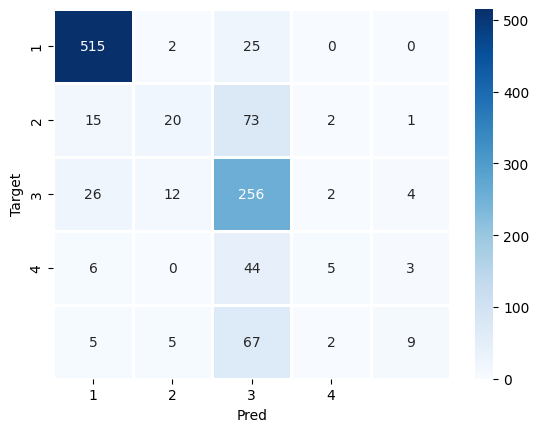

In [ ]:
class_names = [1, 2, 3, 4]
corr = confusion_matrix(y_test, y_pred)
sn.heatmap(corr, cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('Pred')
plt.ylabel('Target');

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier()
clf_dct = GridSearchCV(dct, dt_param_grid, cv=5)
clf_dct.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
clf_dct.best_estimator_

DecisionTreeClassifier(max_depth=5)

In [ ]:
clf_dct.best_score_

0.7011376096491228

In [ ]:
y_pred = clf_dct.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.11      0.19       542
           1       0.00      0.00      0.00       111
           2       0.29      1.00      0.45       300
           3       0.00      0.00      0.00        58
           4       0.00      0.00      0.00        88

    accuracy                           0.33      1099
   macro avg       0.23      0.22      0.13      1099
weighted avg       0.50      0.33      0.22      1099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


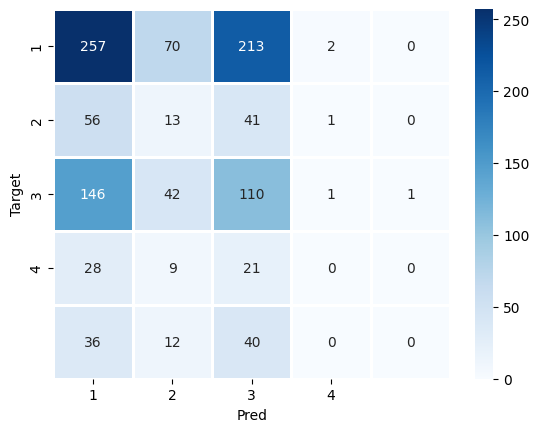

In [ ]:
class_names = [1, 2, 3, 4]
corr = confusion_matrix(y_test, y_pred)
sn.heatmap(corr, cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('Pred')
plt.ylabel('Target');

## SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()
clf_svc = GridSearchCV(svc, svm_param_grid, cv=5)
clf_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'kernel': ['linear', 'rbf']})

In [ ]:
clf_svc.best_estimator_

SVC(C=10)

In [ ]:
y_pred = clf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       542
           1       0.40      0.26      0.32       111
           2       0.55      0.84      0.67       300
           3       0.62      0.14      0.23        58
           4       0.00      0.00      0.00        88

    accuracy                           0.73      1099
   macro avg       0.50      0.44      0.43      1099
weighted avg       0.67      0.73      0.68      1099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


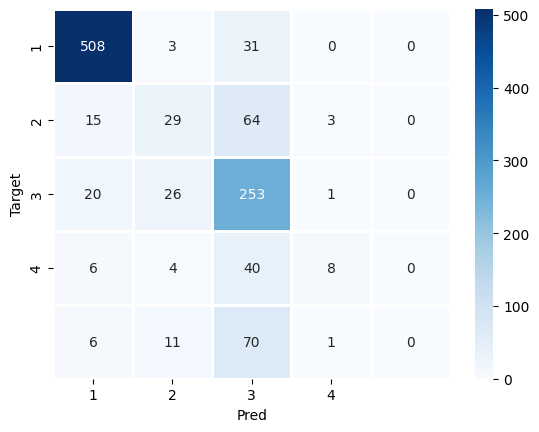

In [ ]:
class_names = [1, 2, 3, 4]
corr = confusion_matrix(y_test, y_pred)
sn.heatmap(corr, cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('Pred')
plt.ylabel('Target');

# Preprocess

In [ ]:
preprocessed_data = Blindness_dataset(image_folder='/content/aptos2019-blindness-detection/train_images',
                         data_csv_path='/content/aptos2019-blindness-detection/train.csv',
                         preprocess=True)


train_data_, test_data_ = train_test_split(preprocessed_data,
                                         test_size=0.3,
                                         random_state=42,
                                         shuffle=True,
                                         stratify=data.data_csv.diagnosis.tolist())

In [ ]:
_, y_train, X_train = zip(*train_data_)
_, y_test, X_test = zip(*test_data_)

In [ ]:
train_data_[0]

('38f1901f214a',
 0,
 array([3.39084201e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.52112269e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.13028067e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.80844907e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.52112269e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.04224537e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.16478588e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.48661748e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.71267361e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.48661748e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.29506655e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.03450521e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.06901042e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.19929109e-05, 0.00000000e+00, 0.0

## Random Forest

In [ ]:
rfc_ = RandomForestClassifier()
clf_rfc_ = GridSearchCV(rfc, rf_param_grid, cv=5)
clf_rfc_.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [ ]:
clf_rfc_.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=200)

In [ ]:
y_pred = clf_rfc_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       542
           1       0.50      0.03      0.05       111
           2       0.53      0.87      0.66       300
           3       0.00      0.00      0.00        58
           4       0.44      0.05      0.08        88

    accuracy                           0.71      1099
   macro avg       0.47      0.38      0.34      1099
weighted avg       0.66      0.71      0.64      1099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
(0.94 + 0.03 + 0.87 + 0 + 0.05)/5

0.378

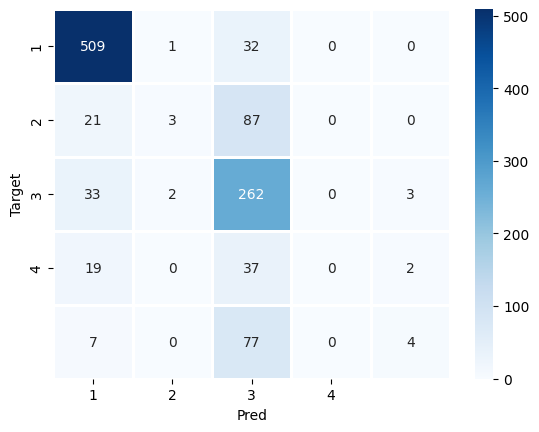

In [ ]:
class_names = [1, 2, 3, 4]
corr = confusion_matrix(y_test, y_pred)
sn.heatmap(corr, cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('Pred')
plt.ylabel('Target');

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dct = DecisionTreeClassifier()
clf_dct_ = GridSearchCV(dct, dt_param_grid, cv=5)
clf_dct_.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10]})

In [ ]:
clf_dct_.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_split=5)

In [ ]:
clf_dct_.best_score_

0.6749809636939571

In [ ]:
y_pred = clf_dct_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       542
           1       0.50      0.05      0.08       111
           2       0.52      0.83      0.64       300
           3       0.67      0.03      0.07        58
           4       0.09      0.01      0.02        88

    accuracy                           0.70      1099
   macro avg       0.53      0.37      0.34      1099
weighted avg       0.66      0.70      0.63      1099



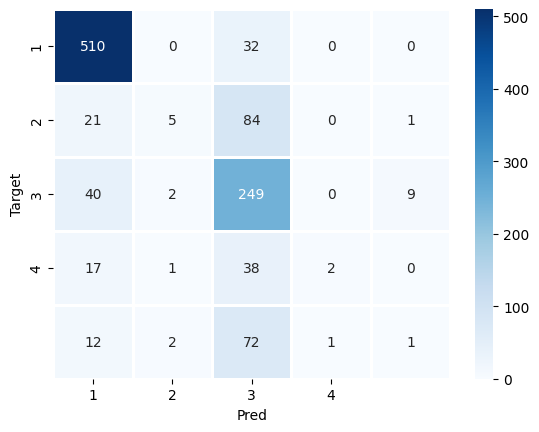

In [ ]:
class_names = [1, 2, 3, 4]
corr = confusion_matrix(y_test, y_pred)
sn.heatmap(corr, cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('Pred')
plt.ylabel('Target');

## SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()
clf_svc_ = GridSearchCV(svc, svm_param_grid, cv=5)
clf_svc_.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'kernel': ['linear', 'rbf']})

In [ ]:
clf_svc_.best_estimator_

SVC(C=100)

In [ ]:
y_pred = clf_svc_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89       542
           1       0.00      0.00      0.00       111
           2       0.51      0.88      0.64       300
           3       0.33      0.03      0.06        58
           4       0.00      0.00      0.00        88

    accuracy                           0.69      1099
   macro avg       0.34      0.37      0.32      1099
weighted avg       0.59      0.69      0.62      1099



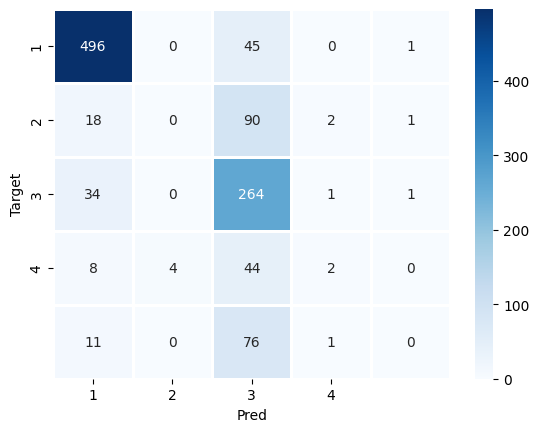

In [ ]:
class_names = [1, 2, 3, 4]
corr = confusion_matrix(y_test, y_pred)
sn.heatmap(corr, cmap='Blues', linewidths=1, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='g')
plt.xlabel('Pred')
plt.ylabel('Target');

# Plot

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import cv2
imgs = glob('/content/aptos2019-blindness-detection/train_images/*')

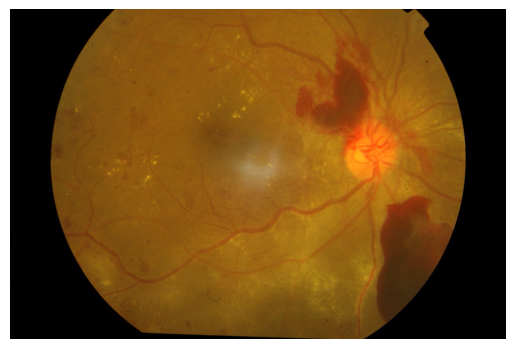

In [ ]:
a = cv2.imread(imgs[0])
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.axis(False)
plt.imshow(a)

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


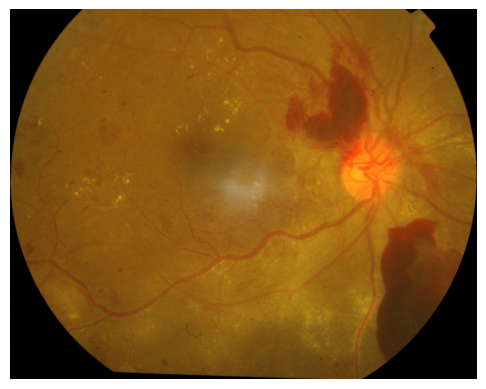

In [ ]:
b = crop_image_from_gray(a)
plt.axis(False)
plt.imshow(b)

In [ ]:
c = cv2.cvtColor(a, cv2.COLOR_RGB2GRAY)
mask = c > 7

In [ ]:
c[:, 123]

array([ 1,  0,  1,  1,  0,  0,  0,  0,  1,  2,  1,  0,  0,  1,  1,  1,  0,
        1,  0,  0,  1,  0,  0,  0,  2,  1,  1,  0,  0,  0,  0,  1,  0,  0,
        2,  1,  1,  1,  2,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  1,
        1,  0,  0,  0,  0,  0,  0,  1,  2,  1,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  1,  2,  0,  0,  1,  1,  0,  1,  1,  1,  2,  2,  1,  0,  0,
        0,  0,  1,  1,  1,  0,  0,  0,  0,  0,  1,  0,  1,  1,  1,  1,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  1,  1,  0,  0,  0,  3,  2,  1,  1,  1,  1,  2,  2,
        0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,
        0,  0,  0,  0,  1,  1,  0,  2,  0,  0,  1,  1,  1,  1,  1,  1,  0,
        0,  1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  2,  1,
        1,  1,  0,  0,  0,  1,  1,  1,  1,  1,  0,  0,  2,  2,  1,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  2,  1,  1,  1,
        1,  1,  2,  1,  1

In [ ]:
a[:, :, 0][np.ix_(mask.any(1),mask.any(0))]

array([[2, 2, 1, ..., 1, 1, 1],
       [2, 1, 1, ..., 1, 1, 1],
       [2, 2, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint8)

In [ ]:
a[:, :, 0]

array([[1, 1, 1, ..., 2, 2, 3],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 2, 2, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 1, 1],
       [1, 2, 2, ..., 1, 1, 1]], dtype=uint8)

In [ ]:
t1, t2 = np.ix_(mask.any(1),mask.any(0))

In [ ]:
len(t1)

1000

In [ ]:
len(t2)

1

In [ ]:
a[:, :, 0][t1, t2]

array([[2, 2, 1, ..., 1, 1, 1],
       [2, 1, 1, ..., 1, 1, 1],
       [2, 2, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 1, 1],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint8)

In [ ]:
t2

array([[ 122,  123,  124, ..., 1380, 1381, 1382]])

In [ ]:
mask.any(0)[122]

True

In [ ]:
a.shape

(1000, 1504, 3)

In [ ]:
mask.any(1).sum()

1000